In [1]:
import pickle
import numpy as np 
import re 
from pathlib import Path
import pandas as pd
import json 
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
from src import util_analysis 

# from matplotlib.ticker import FormatStrFormatter
import re 

In [2]:
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

fig_out_dir = Path("final_figures/figure_2")
fig_out_dir.mkdir(exist_ok=True, parents=True)

## Plot results from Popham-style conditions using SWC stimuli

### Import human data

In [3]:
path_to_human_data = Path('/mindhive/mcdermott/www/imgriff/msjspsych/')
# !ls {path_to_human_data}
# full paths to .json files 
human_fnames = list(path_to_human_data.glob("cocktail_party_popham_swc_word_recognition/data/*.json"))

# import vocab dict for matching audio & responses 
# word_and_speaker_encodings = pickle.load( open("/om2/user/imgriff/projects/Auditory-Attention/word_and_speaker_encodings_jsinv3.pckl", "rb" )) 
# # ix_to_word_map = {v:k for k,v in class_map.items()}
# class_map = word_and_speaker_encodings['word_idx_to_word']
len(human_fnames)


236

## Process Human Results

In [4]:
## Get all subject data into one df for analysis

def get_part_df(fname):
    part_data = json.load(open(fname, 'r'))
    # print(f"{fname.stem} success {part_data[0]['success']}")
    part_df = pd.DataFrame.from_records(part_data)
    ## Forward fill stim presentation entry to word response entry
    responses = part_df.loc[part_df.trial_type.isin(['audio-keyboard-response','dictionary-text']), ['trial_index', 'stimulus']]
    responses = responses.ffill()
    part_df.loc[part_df['trial_index'].isin(responses["trial_index"].values), 'stimulus'] = responses.stimulus
    return part_df

dfs = []
for fname in human_fnames:
    try:
        dfs.append(get_part_df(fname))
    except Exception as e:
        print(e)
        print(fname)
    
# results_df = pd.concat([get_part_df(fname) for fname in human_fnames], axis=0, ignore_index=True)
results_df = pd.concat(dfs)

## Filter for those who passed headphone check 
results_df = results_df[results_df.hc_passed == True]


## Add snr and condition names as columns - unpack from file code in file names 

import re
### Get condition map
with open('swc_popham_exmpt_2024_cond_manifest.pkl', 'rb') as f:
    stim_cond_map = pickle.load(f)

stim_cond_map = {f"condition_{k:02}": v for k,v in stim_cond_map.items()}

## Map wav str to stim_type using condition dict
def get_stim_snr_and_cond(stim_str, stim_cond_map=stim_cond_map):
    target_harm, dist_harm = None,  None 
    if isinstance(stim_str, str) and not stim_str.startswith('<'):
        # print(stim_str)
        cond_str = re.search("condition_(-?\d+)", stim_str)
        if cond_str:
            cond_str = cond_str.group(0)
            target_harm = stim_cond_map[cond_str]['target_harmonicity']
            dist_harm = stim_cond_map[cond_str]['distractor_harmonicity']
            if dist_harm is None:
                dist_harm = 'No Distractor'
            target_harm = target_harm.title()
            dist_harm = dist_harm.title()
        elif 'catch' in stim_str:
            target_harm = 'catch_trial'
            dist_harm = 'No Distractor'
    return target_harm, dist_harm

# add as columns 
results_df['target_harmonicity'], results_df['distractor_harmonicity'] = zip(*results_df['stimulus'].apply(get_stim_snr_and_cond))

# cut down df to only have trial answers (remove other meta data)
expmnt_trial_str = "dictionary-text"
trial_results = results_df[results_df.trial_type == expmnt_trial_str]


# screen based on completion 
total_trials = 192 
full_run_subjects = [subj_id for subj_id, did_all_trials in (trial_results.groupby('id_subject').target_harmonicity.count() == total_trials).items() if did_all_trials == True]
trial_results = trial_results[trial_results.id_subject.isin(full_run_subjects)]

# # Add accuracy 
trial_results['accuracy'] = (trial_results['response'] == trial_results['correct_response']).astype('int')


Unterminated string starting at: line 1 column 72251 (char 72250)
/mindhive/mcdermott/www/imgriff/msjspsych/cocktail_party_popham_swc_word_recognition/data/subj_55b899c5fdf99b7323bc60e0.json
Unterminated string starting at: line 1 column 96293 (char 96292)
/mindhive/mcdermott/www/imgriff/msjspsych/cocktail_party_popham_swc_word_recognition/data/subj_5e83b9e3e3a9da1163fdd0dc.json
Unterminated string starting at: line 1 column 132380 (char 132379)
/mindhive/mcdermott/www/imgriff/msjspsych/cocktail_party_popham_swc_word_recognition/data/subj_5e12202adc79bd8a6c74499b.json
Unterminated string starting at: line 1 column 277004 (char 277003)
/mindhive/mcdermott/www/imgriff/msjspsych/cocktail_party_popham_swc_word_recognition/data/subj_59b5a275c05bb50001eb3c4b.json
Unterminated string starting at: line 1 column 60160 (char 60159)
/mindhive/mcdermott/www/imgriff/msjspsych/cocktail_party_popham_swc_word_recognition/data/subj_5e8fc56be9fe622b8bd9069b.json
Unterminated string starting at: line 1 c

In [5]:
# trial_results.groupby('id_subject').target_harmonicity.count()

In [6]:
catch_trial_particiapnt_performance = trial_results[trial_results.target_harmonicity == 'catch_trial'].groupby('id_subject').accuracy.mean()
print("N total participants ", len(catch_trial_particiapnt_performance))
good_participants = catch_trial_particiapnt_performance[catch_trial_particiapnt_performance >= 11/12].index
print("N good participants ", len(good_participants))

good_results = trial_results[trial_results.id_subject.isin(good_participants)]

analysis_df = good_results[(~good_results.target_harmonicity.isnull()) & (~good_results.response.isna())]
analysis_df = analysis_df[analysis_df.target_harmonicity != 'catch_trial']

# analysis_df.groupby('id_subject').target_harmonicity.count()

N total participants  110
N good participants  90



## Add re-scored performance based on entries included in excerpt transcripts  

In [7]:
meta_df = pd.read_pickle('/om/user/imgriff/datasets/human_swc_popham_exmpt_2024/source_stim_meta_manifest.pdpkl')

analysis_df = pd.merge(analysis_df,
                        meta_df[['word', 'word_int', 'distractor_word', 'target_transcripts', 'distractor_transcripts', 'gender_cond']],
                        left_on=['correct_response'], right_on=['word'], how='left')     
                        
analysis_df['confusions'] = (analysis_df.response == analysis_df.distractor_word).astype('int')
# add adjusted accuracy and confusions 
target_words = analysis_df.response.values
target_transcripts = analysis_df.target_transcripts.values
distractor_transcripts = analysis_df.distractor_transcripts.values
distractor_words = analysis_df.distractor_word.values


adjusted_acc = np.array([int(target_word in target_transcript)
                            if not isinstance(target_transcript, float) else np.nan
                             for target_word, target_transcript in zip(target_words, target_transcripts)
                              ])

adjusted_confs = np.array([int((target_word in distractor_transcript) or (target_word == distractor_word))
                            if not isinstance(distractor_transcript, float) else np.nan
                             for target_word, distractor_word, distractor_transcript in zip(target_words, distractor_words, distractor_transcripts)
                              ])

analysis_df['adjusted_accuracy'] = adjusted_acc
analysis_df['adjusted_confusions'] = adjusted_confs

In [8]:
# get trial data excluding catch trials 


part_summary_df = (analysis_df.groupby(['id_subject', "target_harmonicity", 'distractor_harmonicity'])
                     .agg({'correct':['mean', 'sem'],
                            'confusions':['mean', 'sem'],
                            'adjusted_accuracy':['mean', 'sem'],
                            'adjusted_confusions':['mean', 'sem', 'count']})
                     .reset_index())

# flatten multiindex 
part_summary_df.columns = ['_'.join(col).strip() for col in part_summary_df.columns.values]
# remove trailing underscore
part_summary_df.columns = [col[:-1] if col.endswith('_') else col for col in part_summary_df.columns.values]


## Set paths and load model results 

In [9]:
## import class maps
import pickle
## load WSN vocab mapping 
word_and_speaker_encodings = pickle.load( open( "/om2/user/imgriff/projects/Auditory-Attention/word_and_speaker_encodings_jsinv3.pckl", "rb" )) 
wsn_word_2_class = word_and_speaker_encodings['word_to_idx']
wsn_class_2_word = word_and_speaker_encodings['word_idx_to_word']
cv_word_2_class = pickle.load( open("/om2/user/imgriff/datasets/commonvoice_9/en/cv_800_word_label_to_int_dict.pkl", "rb" )) 
cv_class_2_word = {v:k for k,v in cv_word_2_class.items()}


In [10]:
# parent_path = Path('/om2/user/imgriff/projects/torch_2_aud_attn/popham_mono_eval/')
parent_path = Path('/om2/user/imgriff/projects/torch_2_aud_attn/popham_swc_eval_all_stim/')

# model_name = 'word_task_standard_v08'
# model_name = 'word_task_half_co_loc_v07'

meta_df = pd.read_pickle('/om/user/imgriff/datasets/human_word_rec_SWC_2024/human_cue_target_distractor_df_w_meta_transcripts.pdpkl')
meta_df['expt_df_ix'] = meta_df.index
cols_to_merge = [
                 'gender',
                 'word',
                 'target_transcripts',
                 'same_sex_distractor_1_transcripts',
                 'diff_sex_distractor_1_transcripts',
                 "same_sex_dist_1_word",
                 "diff_sex_dist_1_word",
                 "expt_df_ix"
]

results_dirs = list(parent_path.rglob(f"*/*v10*.csv"))
results_dirs += list(parent_path.rglob(f"*/*50Hz_cutoff*.csv"))
print(len(results_dirs))

dfs = []

for result_csv in results_dirs:
    # print(result_csv)
    # if not 'word_task_half_co_loc_v09_gender_bal_4M_w_no_cue_learned_higher_lr_less_dropout' in str(result_csv) or not '_arch_' in str(result_csv):
    #     # print('skp')
    #     continue
    try:
        df = pd.read_csv(result_csv)
    except Exception as e:
        print(e)
        print(result_csv)
        continue
    
    # break 
    df['target_harmonicity'] = result_csv.stem.split('_target')[0].split('_')[-1].title()
    df['model'] = result_csv.parent.stem
    dist_harm = result_csv.stem.split('_distractor')[0].split('_')[-1].title()
    if dist_harm == 'None':
        dist_harm = 'No Distractor'
    df['distractor_harmonicity'] = dist_harm
    df['target_word'] = df['true_word_int'].replace(cv_class_2_word)
    df['pred_word'] = df['pred_word_int'].replace(cv_class_2_word)
    df = pd.merge(df,
                 meta_df[cols_to_merge],
                 left_on=['target_word','orig_df_row_ix'], right_on=['word', 'expt_df_ix'], how='left')     
    dfs.append(df)

model_results = pd.concat(dfs, axis=0, ignore_index=True)
model_results['confusions'] = (model_results.pred_word == model_results.same_sex_dist_1_word).astype('int') + (model_results.pred_word == model_results.diff_sex_dist_1_word).astype('int')
model_results['accuracy'] = (model_results.pred_word == model_results.target_word).astype('int')
# add adjusted accuracy and confusions 
pred_words = model_results.pred_word.values
target_words = model_results.word.values
target_transcripts = model_results.target_transcripts.values
same_sex_distractor_words = model_results.same_sex_dist_1_word.values
diff_sex_distractor_words = model_results.diff_sex_dist_1_word.values
same_sex_distractor_transcripts = model_results.same_sex_distractor_1_transcripts.values
diff_sex_distractor_transcripts = model_results.diff_sex_distractor_1_transcripts.values


adjusted_acc = np.array([int(pred_word in target_transcript or pred_word == target_word)
                            if not isinstance(target_transcript, float) else np.nan
                            for pred_word, target_word, target_transcript in zip(pred_words, target_words, target_transcripts)
                            ])

adjusted_confs = np.array([int(pred_word in same_sex_transcript or pred_word in diff_sex_transcript or pred_word == same_sex_word or pred_word == diff_sex_word)
                            if not (isinstance(same_sex_transcript, float) and isinstance(diff_sex_transcript, float)) else np.nan
                            for pred_word, same_sex_word, diff_sex_word, same_sex_transcript, diff_sex_transcript in zip(pred_words, same_sex_distractor_words, diff_sex_distractor_words,  same_sex_distractor_transcripts, diff_sex_distractor_transcripts)
                            ])

model_results['adjusted_accuracy'] = adjusted_acc
model_results['adjusted_confusions'] = adjusted_confs


174


### Conform data to plot 

In [11]:
### Summarize models like participants 

model_summary_df = (model_results.groupby(['model', "target_harmonicity", 'distractor_harmonicity']).agg({'accuracy':['mean', 'sem'],
                            'confusions':['mean', 'sem'],
                            'adjusted_accuracy':['mean', 'sem'],
                            'adjusted_confusions':['mean', 'sem', 'count']})
                     .reset_index())

# flatten multiindex 
model_summary_df.columns = ['_'.join(col).strip() for col in model_summary_df.columns.values]
# remove trailing underscore
model_summary_df.columns = [col[:-1] if col.endswith('_') else col for col in model_summary_df.columns.values]

In [12]:

melted_model_results = pd.melt(model_summary_df, id_vars=['target_harmonicity', 'model', 'distractor_harmonicity'],
        value_vars=['adjusted_accuracy_mean', 'adjusted_confusions_mean'],
        value_name = 'hits',
        var_name = 'attended_stream')

# group_name_df = {
#                 'word_task_half_co_loc_v07': "Feature-based\nattention model",
#                  "word_task_v08_control_no_attn": "Baseline CNN",
#                  "word_task_half_co_loc_v09_50Hz_cutoff": "50Hz cutoff model",
#                  "word_task_half_co_loc_v08_gender_bal_4M_w_no_cue_learned_higher_lr_less_dropout": "v08 model",
#                 "word_task_conventional_layer_order": "Conventional Layer Order",

#                  "word_task_half_co_loc_v09_gender_bal_4M_w_no_cue_learned_higher_lr_less_dropout": "Feature-gain model"}

# group_name_df = util_analysis.model_name_dict


# melted_model_results['attended_stream'][melted_model_results['attended_stream'] == 'accuracy'] = "Cued stream"
# melted_model_results['attended_stream'][melted_model_results['attended_stream'] == 'confusions']= "Uncued stream"
melted_model_results.loc[melted_model_results['attended_stream'] == 'adjusted_accuracy_mean', 'attended_stream'] = "Target"
melted_model_results.loc[melted_model_results['attended_stream'] == 'adjusted_confusions_mean', 'attended_stream'] =  "Distractor"

IDX_no_dist_confs = melted_model_results.loc[(melted_model_results['distractor_harmonicity'] == 'No Distractor') & (melted_model_results.attended_stream == 'Distractor') ].index.values
melted_model_results = melted_model_results[~melted_model_results.index.isin(IDX_no_dist_confs)]
melted_model_results.loc[melted_model_results['distractor_harmonicity'] == 'No Distractor', 'attended_stream'] = "Single sentence"
melted_model_results.loc[melted_model_results.model.str.contains("early_only"), 'group'] = "Early-only model"
melted_model_results.loc[melted_model_results.model.str.contains("late_only"), 'group'] = "Late-only model"
melted_model_results.loc[melted_model_results.model.str.contains("control"), 'group'] = "Baseline CNN"
melted_model_results.loc[melted_model_results.model.str.contains("50Hz"), 'group'] = "50Hz model"
melted_model_results.loc[melted_model_results.model.str.contains("backbone"), 'group'] = "Computed-gain model"
melted_model_results.loc[~melted_model_results.model.str.contains("late|early|control|50Hz|backbone"), 'group'] = "Feature-gain model"

/tmp/ipykernel_3498534/93083061.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels, rotation=45, fontsize=tick_fontsize, ha='right', rotation_mode='anchor')
/tmp/ipykernel_3498534/93083061.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels, rotation=45, fontsize=tick_fontsize, ha='right', rotation_mode='anchor')
/tmp/ipykernel_3498534/93083061.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels, rotation=45, fontsize=tick_fontsize, ha='right', rotation_mode='anchor')
/tmp/ipykernel_3498534/93083061.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set

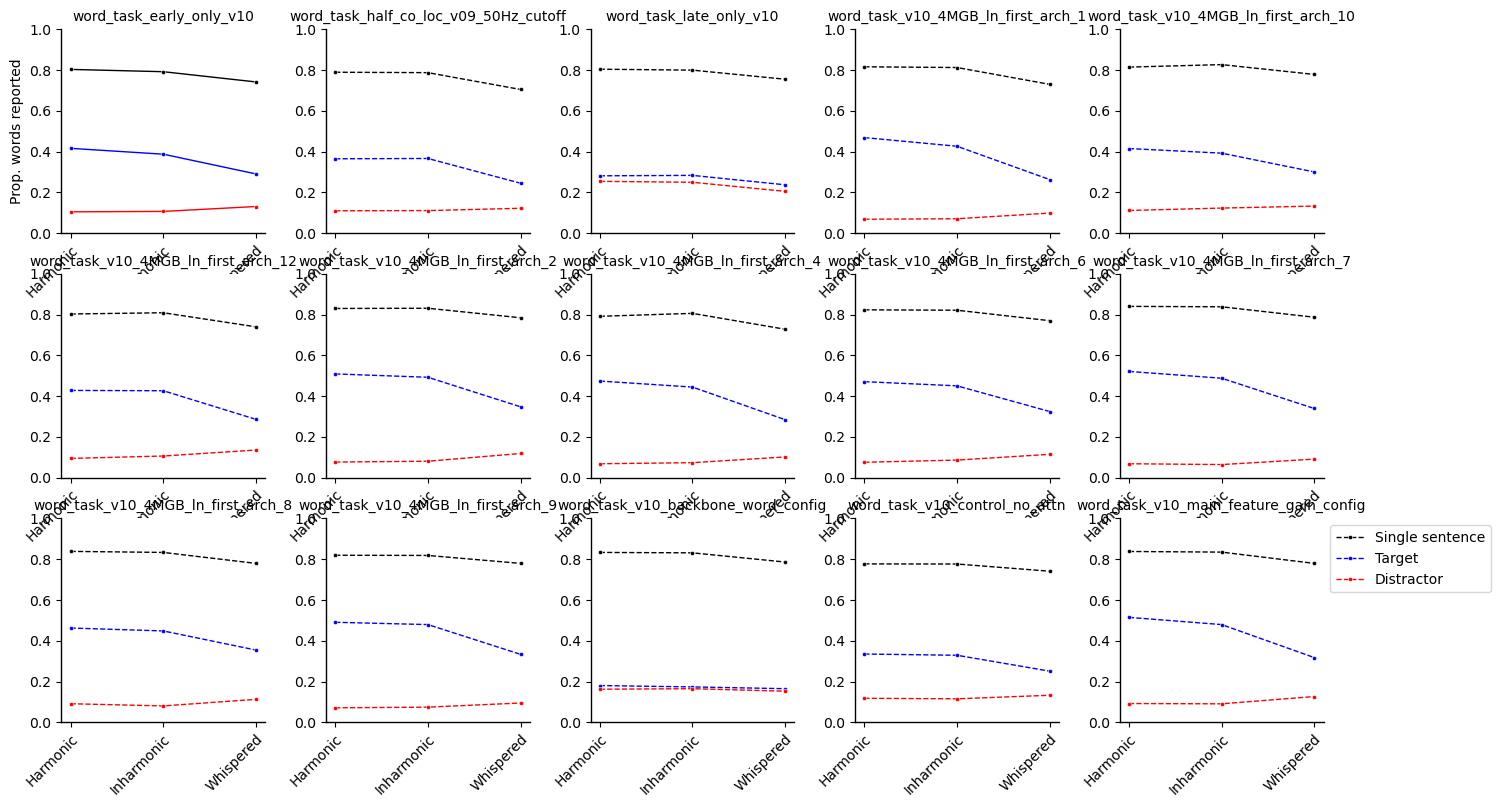

In [13]:
# def draw_stats_bar(ax, x1, x2, y, h, th=0.025, lw=1.5, col='k', fontsize=10):





groups_to_plot = melted_model_results.model.unique()

n_models = len(groups_to_plot)

to_plot = melted_model_results[melted_model_results.model.isin(groups_to_plot)]
to_plot = to_plot[(to_plot.target_harmonicity == to_plot.distractor_harmonicity) | (to_plot.distractor_harmonicity == 'No Distractor')]

no_dist_IXS = to_plot[to_plot.distractor_harmonicity == 'No Distractor'].index.values
to_plot.loc[no_dist_IXS, 'distractor_harmonicity'] = to_plot.loc[no_dist_IXS, 'target_harmonicity'] 
to_plot =to_plot[to_plot.distractor_harmonicity != 'No Distractor']


hues = ['k', 'b', 'r']
hue_order = ['Single sentence', 'Target', 'Distractor']

palette = {'Target': 'b', 'Distractor': 'r', 'Single sentence': 'k'}

fontsize=10
tick_fontsize = 10
# fontsize = 10
err_band_alpha = 0.2

yticks = np.linspace(0,1,6).round(1)

xtick_labels = to_plot.distractor_harmonicity.unique()
xticks = np.arange(len(xtick_labels))
ratio = 1.0 
line_thickness = 1


aspect = 3
n_rows = 3
n_cols = n_models // n_rows
n_cols += n_models % n_rows

fig, axs = plt.subplots(n_rows, n_cols, figsize=((aspect) * (n_cols + .5), aspect * n_rows))
axs = axs.ravel()

for ax, model in zip(axs, groups_to_plot):

    sns.lineplot(data=to_plot[to_plot.model == model],  x='distractor_harmonicity', y='hits', 
                hue = 'attended_stream', hue_order=hue_order,
                palette=hues,
                ax=ax,
                errorbar=('se', 1), err_style='band', err_kws={'alpha':err_band_alpha},
                marker='.', 
                 )
    ax.set_title(model, fontsize=fontsize)
    ax.set_xlabel('')
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticklabels(xtick_labels, rotation=45, fontsize=tick_fontsize, ha='right', rotation_mode='anchor')
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
    #     line.set_markerfacecolor(line.get_color())
    #     line.set_markeredgecolor('w')
        line.set_linewidth(1)
        line.set_markersize(6)
        line.set_markeredgewidth(.4)
        if model != groups_to_plot[0]:
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')


## Add p-values to plot

# set up x and y positions for p-value text
x_coord_dict = {'Harmonic_Inharmonic': {'x1': 0, 'x2': 1},
                'Harmonic_Whispered': {'x1': 0, 'x2': 2},
                'Inharmonic_Whispered': {'x1': 1, 'x2': 2}}

# get y_pos for p-value text for target stream from data
group_max = to_plot[(to_plot.attended_stream == 'Target') & (to_plot.distractor_harmonicity == 'Harmonic')].groupby(['group']).hits.mean()
inharmonic_max = to_plot[(to_plot.attended_stream == 'Target') & (to_plot.distractor_harmonicity == 'Inharmonic')].groupby(['group']).hits.mean()
h = 0.025
ver_shift_increment = 0.04

sns.despine()

for ix in range(n_models-1):
    axs[ix].legend().remove()

axs[0].set_ylabel("Prop. words reported", fontsize=fontsize)
for ix in range(1, n_models):
    axs[ix].set_ylabel("", fontsize=fontsize)

# move axs[1] legend 
axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize)

# plt.tight_layout()
# plt.savefig(outfig_dest/'harmonicity_human_arch_sum_v09.pdf', transparent=True, bbox_inches='tight')


In [14]:
melted_participant_results = pd.melt(part_summary_df, id_vars=['id_subject', 'target_harmonicity', 'distractor_harmonicity'],
        value_vars=['adjusted_accuracy_mean', 'adjusted_confusions_mean'],
        value_name = 'hits',
        var_name = 'attended_stream')

melted_participant_results.loc[melted_participant_results['attended_stream'] == 'adjusted_accuracy_mean', 'attended_stream'] = "Target"
melted_participant_results.loc[melted_participant_results['attended_stream'] == 'adjusted_confusions_mean', 'attended_stream'] =  "Distractor"

IDX_no_dist_confs = melted_participant_results.loc[(melted_participant_results['distractor_harmonicity'] == 'No Distractor') & (melted_participant_results.attended_stream == 'Distractor') ].index.values
melted_participant_results = melted_participant_results[~melted_participant_results.index.isin(IDX_no_dist_confs)]
melted_participant_results.loc[melted_participant_results['distractor_harmonicity'] == 'No Distractor', 'attended_stream'] = "Single sentence"
melted_participant_results['group'] = f'Humans (N = {melted_participant_results.id_subject.nunique()})'

### Save out human and model results for offline analysis 

In [15]:
# ### Summarize over participants 
# human_summary_df = melted_participant_results.groupby(['group', 'target_harmonicity', 'distractor_harmonicity', 'attended_stream']).agg({"hits":['mean', 'sem']}).reset_index()
# human_summary_df.columns = ['group', 'target_harmonicity', 'distractor_harmonicity', 'attended_stream', 'hits_mean', 'hits_sem']

#### merge human and model results

In [43]:
melted_results = pd.concat([melted_participant_results, melted_model_results], axis=0, ignore_index=True)
melted_results = melted_results[~melted_results.group.str.contains('50|Computed')].reset_index(drop=True)

In [45]:
results_dir = Path('final_results_dir')
melted_results.to_csv(results_dir / 'experiment_2_df_for_plot_and_stats.csv', index=False)

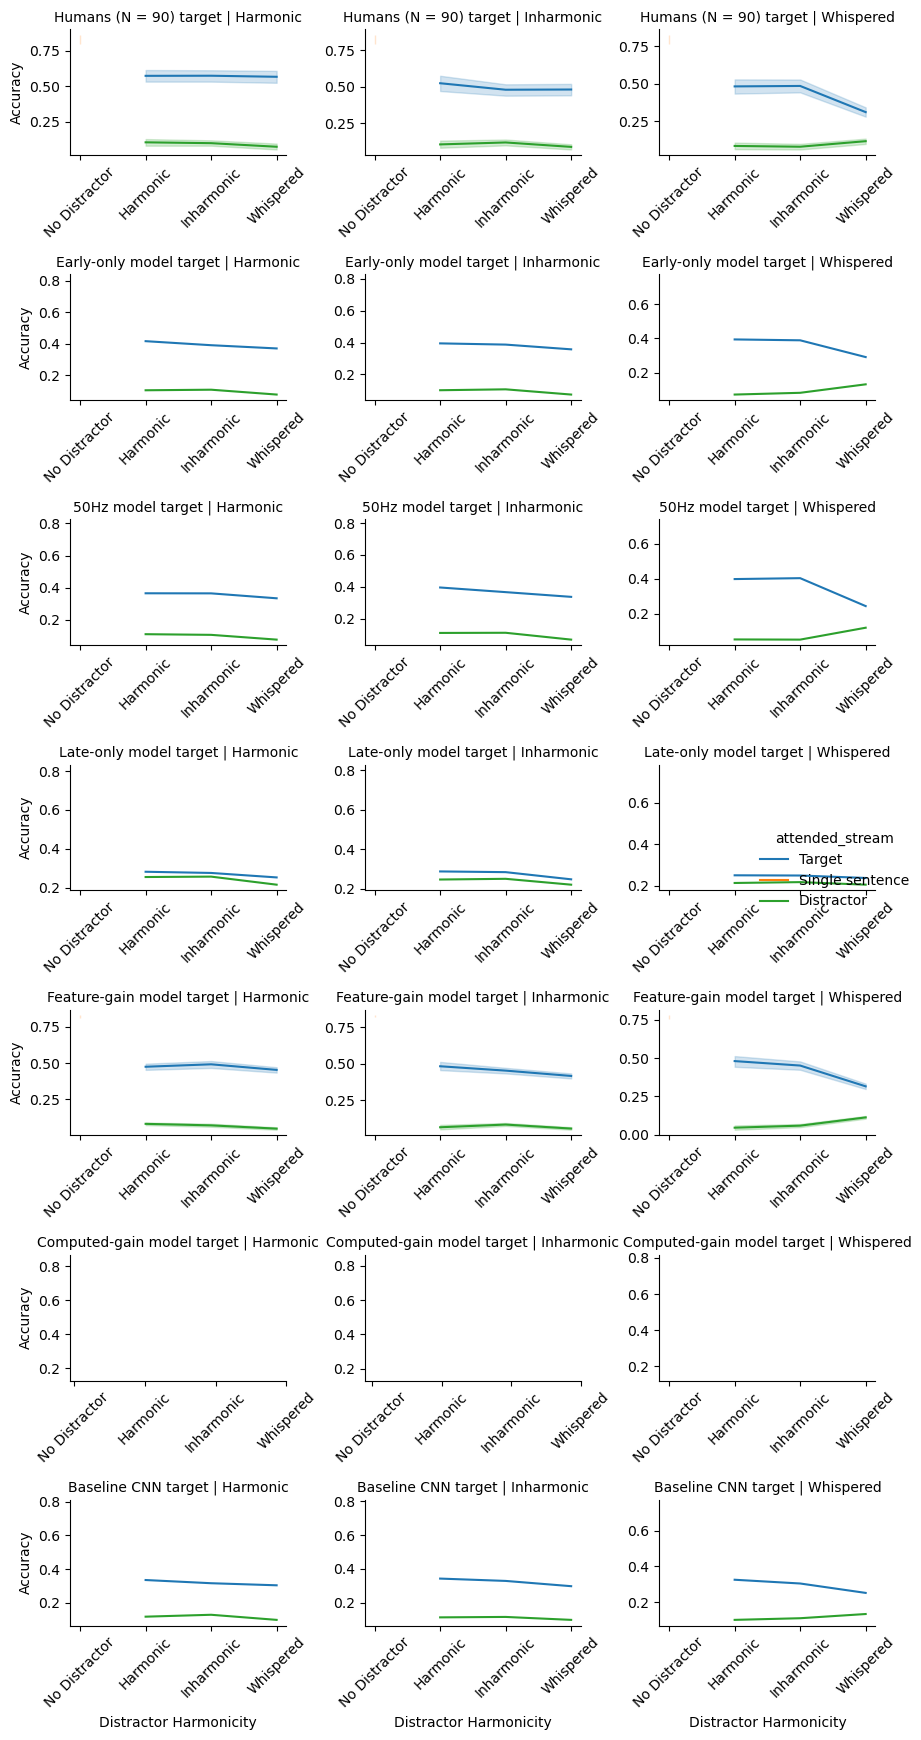

In [18]:
to_plot = melted_results.copy() # [melted_model_results.model.isin(groups_to_plot)]
# to_plot = to_plot[(to_plot.target_harmonicity == to_plot.distractor_harmonicity) | (to_plot.distractor_harmonicity == 'No Distractor')]

# no_dist_IXS = to_plot[to_plot.distractor_harmonicity == 'No Distractor'].index.values
# to_plot.loc[no_dist_IXS, 'distractor_harmonicity'] = to_plot.loc[no_dist_IXS, 'target_harmonicity'] 
# to_plot = to_plot[to_plot.distractor_harmonicity != 'No Distractor']


to_plot['distractor_harmonicity'] = pd.Categorical(to_plot['distractor_harmonicity'], categories=['No Distractor', 'Harmonic', 'Inharmonic', 'Whispered'], ordered=True)
to_plot['target_harmonicity'] = pd.Categorical(to_plot['target_harmonicity'], categories=['No Distractor', 'Harmonic', 'Inharmonic', 'Whispered'], ordered=True)


g = sns.relplot(data=to_plot,
            x='distractor_harmonicity',
            y='hits',
            hue='attended_stream',
            col='target_harmonicity',
            row='group',
            kind='line',
            height=2.5,
            aspect=1,
            # palette=hues,

            col_order=['Harmonic', 'Inharmonic', 'Whispered'],
            facet_kws={'sharey': False, 'sharex': False}

            )
g.set_axis_labels("Distractor Harmonicity", "Accuracy")
g.set_titles(col_template="{col_name}", row_template="{row_name} target")
# turn of sharex
# rotate x ticks 
g.set_xticklabels(rotation=45)
plt.tight_layout()

In [19]:
melted_results.groupby('group').attended_stream.count()

group
50Hz model               21
Baseline CNN             21
Computed-gain model       9
Early-only model         21
Feature-gain model      208
Humans (N = 90)        1890
Late-only model          21
Name: attended_stream, dtype: int64

In [20]:
outfig_dest = Path('Paper_figs/mono_results/')
outfig_dest.mkdir(parents=True, exist_ok=True)

## Run statistics 

In [21]:
groups_to_measure = melted_results.group.unique()
groups_to_measure

array(['Humans (N = 90)', 'Early-only model', '50Hz model',
       'Late-only model', 'Feature-gain model', 'Computed-gain model',
       'Baseline CNN'], dtype=object)

In [22]:
melted_results.model.unique()

array([nan, 'word_task_early_only_v10',
       'word_task_half_co_loc_v09_50Hz_cutoff', 'word_task_late_only_v10',
       'word_task_v10_4MGB_ln_first_arch_1',
       'word_task_v10_4MGB_ln_first_arch_10',
       'word_task_v10_4MGB_ln_first_arch_12',
       'word_task_v10_4MGB_ln_first_arch_2',
       'word_task_v10_4MGB_ln_first_arch_4',
       'word_task_v10_4MGB_ln_first_arch_6',
       'word_task_v10_4MGB_ln_first_arch_7',
       'word_task_v10_4MGB_ln_first_arch_8',
       'word_task_v10_4MGB_ln_first_arch_9',
       'word_task_v10_backbone_word_config',
       'word_task_v10_control_no_attn',
       'word_task_v10_main_feature_gain_config'], dtype=object)

In [23]:
import scipy.stats as stats

# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = np.mean(d1), np.mean(d2)
	# calculate the effect size
	return (u1 - u2) / s

## Cohen's d for paired samples
def cohend_paired(d1, d2):
    # is difference of means, divided by standard deviation of differences
    return (np.mean(d1) - np.mean(d2))/ np.std(d1 - d2, ddof=1)


#### Paired t-test for human single sentence harmonic vs inharmonic and harmonic vs whispered 


In [24]:
ttest_results = []


human_for_stats = melted_participant_results[melted_participant_results.attended_stream == 'Single sentence']

harmonic_hits = human_for_stats[human_for_stats.target_harmonicity == 'Harmonic'].hits.values
inharmonic_hits = human_for_stats[human_for_stats.target_harmonicity == 'Inharmonic'].hits.values
whispered_hits = human_for_stats[human_for_stats.target_harmonicity == 'Whispered'].hits.values

## ttest harmonic vs inharmonic
result  = stats.ttest_rel(harmonic_hits, inharmonic_hits)
harm_inharm_d = cohend_paired(harmonic_hits, inharmonic_hits)

print(f"Harmonic vs Inharmonic single sentence ttest: t({result.df}) = {result.statistic:.2f}, p = {result.pvalue:.2f} d = {harm_inharm_d:.2f} ")
record = {'group': 'Humans', 'stream': 'Single sentence', 'comparison': 'Harmonic vs Inharmonic', 't': result.statistic, 'p': result.pvalue, 'd': harm_inharm_d}
ttest_results.append(record)

## ttest harmonic vs whispered
result= stats.ttest_rel(harmonic_hits, whispered_hits)  
harm_whisp_d = cohend_paired(harmonic_hits, whispered_hits)

print(f"Harmonic vs Whispered single sentence ttest: t({result.df}) = {result.statistic:.2f}, p = {result.pvalue:.2f} d = {harm_whisp_d:.2f}")
print('\n')
record = {'group': 'Humans', 'stream': 'Single sentence', 'comparison': 'Harmonic vs Whispered', 't': result.statistic, 'p': result.pvalue, 'd': harm_whisp_d}
ttest_results.append(record)


data_to_measure = melted_results[melted_results.group.str.contains('Human')]
data_to_measure = data_to_measure[(data_to_measure.target_harmonicity == data_to_measure.distractor_harmonicity) | (data_to_measure.distractor_harmonicity == 'No Distractor')]
data_to_measure = data_to_measure[data_to_measure.attended_stream == 'Target']

harmonic_hits = data_to_measure[data_to_measure.target_harmonicity == 'Harmonic'].hits.values
inharmonic_hits = data_to_measure[data_to_measure.target_harmonicity == 'Inharmonic'].hits.values
whispered_hits = data_to_measure[data_to_measure.target_harmonicity == 'Whispered'].hits.values

## ttest harmonic vs inharmonic
harm_inharm_result  = stats.ttest_rel(harmonic_hits, inharmonic_hits)
harm_inharm_cohens_d = cohend_paired(harmonic_hits, inharmonic_hits)
print(f"Harmonic vs Inharmonic target stream ttest: t({harm_inharm_result.df}) = {harm_inharm_result.statistic:.3f}, p = {harm_inharm_result.pvalue:.4f}, d = {harm_inharm_cohens_d:.2f}")
record = {'group': 'Humans', 'stream': 'Target', 'comparison': 'Harmonic vs Inharmonic', 't': harm_inharm_result.statistic, 'p': harm_inharm_result.pvalue, 'd': harm_inharm_cohens_d}
ttest_results.append(record)

## ttest harmonic vs whispered
harm_whispered_result= stats.ttest_rel(harmonic_hits, whispered_hits)
harm_whispered_cohens_d = cohend_paired(harmonic_hits, whispered_hits)
print(f"Harmonic vs Whispered target stream ttest: t({harm_whispered_result.df}) = {harm_whispered_result.statistic:.3f}, p = {harm_whispered_result.pvalue:.4f}, d = {harm_whispered_cohens_d:.2f}")
record = {'group': 'Humans', 'stream': 'Target', 'comparison': 'Harmonic vs Whispered', 't': harm_whispered_result.statistic, 'p': harm_whispered_result.pvalue, 'd': harm_whispered_cohens_d}
ttest_results.append(record)

Harmonic vs Inharmonic single sentence ttest: t(89) = 0.18, p = 0.86 d = 0.02 
Harmonic vs Whispered single sentence ttest: t(89) = 1.99, p = 0.05 d = 0.21


Harmonic vs Inharmonic target stream ttest: t(89) = 4.413, p = 0.0000, d = 0.47
Harmonic vs Whispered target stream ttest: t(89) = 13.290, p = 0.0000, d = 1.40


#### Test for interaction between Harmonicity and cued/uncued stream 

In [25]:
ttest_results

[{'group': 'Humans',
  'stream': 'Single sentence',
  'comparison': 'Harmonic vs Inharmonic',
  't': 0.1773693316675392,
  'p': 0.8596213433608503,
  'd': 0.01869636917104194},
 {'group': 'Humans',
  'stream': 'Single sentence',
  'comparison': 'Harmonic vs Whispered',
  't': 1.9919698778105666,
  'p': 0.04943950926403321,
  'd': 0.209972061477621},
 {'group': 'Humans',
  'stream': 'Target',
  'comparison': 'Harmonic vs Inharmonic',
  't': 4.413068865126256,
  'p': 2.8509006453561024e-05,
  'd': 0.4651783028324455},
 {'group': 'Humans',
  'stream': 'Target',
  'comparison': 'Harmonic vs Whispered',
  't': 13.290221540572281,
  'p': 7.581978412473456e-23,
  'd': 1.4009123558813434}]

In [26]:
melted_participant_results

,id_subject,target_harmonicity,distractor_harmonicity,attended_stream,hits,group
0,56259489ed6e5a0005c80fde,Harmonic,Harmonic,Target,0.933333,Humans (N = 90)
1,56259489ed6e5a0005c80fde,Harmonic,Inharmonic,Target,0.466667,Humans (N = 90)
2,56259489ed6e5a0005c80fde,Harmonic,No Distractor,Single sentence,0.800000,Humans (N = 90)
3,56259489ed6e5a0005c80fde,Harmonic,Whispered,Target,0.733333,Humans (N = 90)
4,56259489ed6e5a0005c80fde,Inharmonic,Harmonic,Target,0.733333,Humans (N = 90)
...,...,...,...,...,...,...
2153,6679a7429f703992d1619bdc,Inharmonic,Inharmonic,Distractor,0.066667,Humans (N = 90)
2155,6679a7429f703992d1619bdc,Inharmonic,Whispered,Distractor,0.133333,Humans (N = 90)
2156,6679a7429f703992d1619bdc,Whispered,Harmonic,Distractor,0.000000,Humans (N = 90)
2157,6679a7429f703992d1619bdc,Whispered,Inharmonic,Distractor,0.000000,Humans (N = 90)


In [27]:
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
from statsmodels.formula.api import ols

for_stats = melted_participant_results[(melted_participant_results.target_harmonicity == melted_participant_results.distractor_harmonicity) | (melted_participant_results.distractor_harmonicity == 'No Distractor')].copy()
for_stats = for_stats[for_stats.attended_stream != 'Distractor']

human_rm_anova_table = AnovaRM(for_stats, 'hits', 'id_subject', within=['target_harmonicity', 'attended_stream'], aggregate_func='mean').fit()
print("ANOVA for humans")
print(human_rm_anova_table)

## Run model anova 

for_stats = melted_results[(melted_results.target_harmonicity == melted_results.distractor_harmonicity) | (melted_results.distractor_harmonicity == 'No Distractor')]
for_stats = for_stats[(for_stats.group.str.contains("Feature")) & (for_stats.attended_stream != 'Distractor')]

rm_anova_table = AnovaRM(for_stats, 'hits', 'model', within=['target_harmonicity', 'attended_stream'], aggregate_func='mean').fit()
print("ANOVA for Feature-gain models")
print(rm_anova_table)

ANOVA for humans
                               Anova
                                    F Value  Num DF  Den DF  Pr > F
-------------------------------------------------------------------
target_harmonicity                   64.0203 2.0000 178.0000 0.0000
attended_stream                    1018.5367 1.0000  89.0000 0.0000
target_harmonicity:attended_stream   51.0209 2.0000 178.0000 0.0000

ANOVA for Feature-gain models
                              Anova
                                    F Value  Num DF  Den DF Pr > F
------------------------------------------------------------------
target_harmonicity                  260.7245 2.0000 18.0000 0.0000
attended_stream                    3271.4776 1.0000  9.0000 0.0000
target_harmonicity:attended_stream  116.1505 2.0000 18.0000 0.0000



#### Run with pingouin to make sure result is stable

In [40]:
for_stats

,id_subject,target_harmonicity,distractor_harmonicity,attended_stream,hits,group,model
0,56259489ed6e5a0005c80fde,Harmonic,Harmonic,Target,0.933333,Humans (N = 90),NaN
2,56259489ed6e5a0005c80fde,Harmonic,No Distractor,Single sentence,0.800000,Humans (N = 90),NaN
5,56259489ed6e5a0005c80fde,Inharmonic,Inharmonic,Target,0.333333,Humans (N = 90),NaN
6,56259489ed6e5a0005c80fde,Inharmonic,No Distractor,Single sentence,0.933333,Humans (N = 90),NaN
10,56259489ed6e5a0005c80fde,Whispered,No Distractor,Single sentence,0.933333,Humans (N = 90),NaN
...,...,...,...,...,...,...,...
2045,NaN,Inharmonic,No Distractor,Single sentence,0.776639,Baseline CNN,word_task_v10_control_no_attn
2049,NaN,Whispered,No Distractor,Single sentence,0.741291,Baseline CNN,word_task_v10_control_no_attn
2053,NaN,Harmonic,No Distractor,Single sentence,0.838115,Feature-gain model,word_task_v10_main_feature_gain_config
2057,NaN,Inharmonic,No Distractor,Single sentence,0.835041,Feature-gain model,word_task_v10_main_feature_gain_config


In [41]:
from pingouin import rm_anova

for_stats = melted_results[melted_results.group.str.contains('Human')].copy()
for_stats = for_stats[(for_stats.target_harmonicity == for_stats.distractor_harmonicity) | (for_stats.distractor_harmonicity == 'No Distractor')].copy()
for_stats = for_stats[for_stats.attended_stream != 'Distractor']

human_rm_anova_table = rm_anova(data=for_stats, dv='hits', subject='id_subject', within=['target_harmonicity', 'attended_stream'], effsize='np2')
print("ANOVA for humans")
human_rm_anova_table



ANOVA for humans


/om2/user/imgriff/conda_envs/pytorch_2_sva/lib/python3.11/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/om2/user/imgriff/conda_envs/pytorch_2_sva/lib/python3.11/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,target_harmonicity,2.038584,2,178,1.019292,64.020283,1.129925e-21,1.793054e-21,0.418378,0.989510
1,attended_stream,17.785185,1,89,17.785185,1018.536702,1.650891e-50,1.650891e-50,0.919641,1.000000
2,target_harmonicity * attended_stream,1.204346,2,178,0.602173,51.020921,3.051687e-18,4.445109e-18,0.364381,0.989625


In [37]:
melted_results[melted_results.group.str.contains('Human')]

,id_subject,target_harmonicity,distractor_harmonicity,attended_stream,hits,group,model
0,56259489ed6e5a0005c80fde,Harmonic,Harmonic,Target,0.933333,Humans (N = 90),NaN
1,56259489ed6e5a0005c80fde,Harmonic,Inharmonic,Target,0.466667,Humans (N = 90),NaN
2,56259489ed6e5a0005c80fde,Harmonic,No Distractor,Single sentence,0.800000,Humans (N = 90),NaN
3,56259489ed6e5a0005c80fde,Harmonic,Whispered,Target,0.733333,Humans (N = 90),NaN
4,56259489ed6e5a0005c80fde,Inharmonic,Harmonic,Target,0.733333,Humans (N = 90),NaN
...,...,...,...,...,...,...,...
1885,6679a7429f703992d1619bdc,Inharmonic,Inharmonic,Distractor,0.066667,Humans (N = 90),NaN
1886,6679a7429f703992d1619bdc,Inharmonic,Whispered,Distractor,0.133333,Humans (N = 90),NaN
1887,6679a7429f703992d1619bdc,Whispered,Harmonic,Distractor,0.000000,Humans (N = 90),NaN
1888,6679a7429f703992d1619bdc,Whispered,Inharmonic,Distractor,0.000000,Humans (N = 90),NaN


In [31]:
## Run model anova 

for_stats = melted_results[(melted_results.target_harmonicity == melted_results.distractor_harmonicity) | (melted_results.distractor_harmonicity == 'No Distractor')]
for_stats = for_stats[(for_stats.group.str.contains("Feature")) & (for_stats.attended_stream != 'Distractor')]

rm_anova_table = rm_anova(data=for_stats, dv='hits', subject='model', within=['target_harmonicity', 'attended_stream'], effsize='np2')
print("ANOVA for Feature-gain models")
rm_anova_table

ANOVA for Feature-gain models


/om2/user/imgriff/conda_envs/pytorch_2_sva/lib/python3.11/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/om2/user/imgriff/conda_envs/pytorch_2_sva/lib/python3.11/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,target_harmonicity,0.142167,2,18,0.071083,260.724530,5.127416e-14,7.332548e-09,0.966633,0.574539
1,attended_stream,2.270843,1,9,2.270843,3271.477551,7.684967e-13,7.684967e-13,0.997256,1.000000
2,target_harmonicity * attended_stream,0.029979,2,18,0.014989,116.150546,5.143845e-11,5.620524e-08,0.928087,0.666809


In [29]:
melted_results.group.unique()   

array(['Humans (N = 90)', 'Early-only model', '50Hz model',
       'Late-only model', 'Feature-gain model', 'Computed-gain model',
       'Baseline CNN'], dtype=object)

In [30]:
data_to_measure = melted_results[(melted_results.group.str.contains('Feature')) & (melted_results.attended_stream != 'Distractor')]
data_to_measure = data_to_measure[(data_to_measure.target_harmonicity == data_to_measure.distractor_harmonicity) | (data_to_measure.distractor_harmonicity == 'No Distractor')]


In [31]:
### Add model results to ttest results

for group in ['Feature-gain model',]: # 'Early-only model', 'Late-only model', 'Baseline model']:
    data_to_measure = melted_results[(melted_results.group == group) & (melted_results.attended_stream != 'Distractor')]
    data_to_measure = data_to_measure[(data_to_measure.target_harmonicity == data_to_measure.distractor_harmonicity) | (data_to_measure.distractor_harmonicity == 'No Distractor')]
    print(f"Model: {group}")
    for stream in ['Single sentence', 'Target']:

        if stream == 'Single sentence':
            harmonic_hits = data_to_measure[(data_to_measure.target_harmonicity == 'Harmonic') & (data_to_measure.distractor_harmonicity == 'No Distractor')].hits.values
            inharmonic_hits = data_to_measure[(data_to_measure.target_harmonicity == 'Inharmonic') & (data_to_measure.distractor_harmonicity == 'No Distractor')].hits.values
            whispered_hits = data_to_measure[(data_to_measure.target_harmonicity == 'Whispered') & (data_to_measure.distractor_harmonicity == 'No Distractor')].hits.values

        elif stream == 'Target':
            harmonic_hits = data_to_measure[(data_to_measure.target_harmonicity == 'Harmonic') & (data_to_measure.distractor_harmonicity == 'Harmonic')].hits.values
            inharmonic_hits = data_to_measure[(data_to_measure.target_harmonicity == 'Inharmonic') & (data_to_measure.distractor_harmonicity == 'Inharmonic')].hits.values
            whispered_hits = data_to_measure[(data_to_measure.target_harmonicity == 'Whispered') & (data_to_measure.distractor_harmonicity == 'Whispered')].hits.values


        ## ttest harmonic vs inharmonic
        harm_inharm_result  = stats.ttest_rel(harmonic_hits, inharmonic_hits)
        harm_inharm_cohens_d = cohend_paired(harmonic_hits, inharmonic_hits)
        print(f"Harmonic vs Inharmonic {stream} stream ttest: t({harm_inharm_result.df}) = {harm_inharm_result.statistic:.3f}, p = {harm_inharm_result.pvalue:.4f}, d = {harm_inharm_cohens_d:.3f}")
        record = {'group': group, 'stream': stream, 'comparison': 'Harmonic vs Inharmonic', 't': harm_inharm_result.statistic, 'p': harm_inharm_result.pvalue, 'd': harm_inharm_cohens_d}
        ttest_results.append(record)

        ## ttest harmonic vs whispered
        harm_whispered_result= stats.ttest_rel(harmonic_hits, whispered_hits)
        harm_whispered_cohens_d = cohend_paired(harmonic_hits, whispered_hits)
        print(f"Harmonic vs Whispered {stream} stream ttest: t({harm_whispered_result.df}) = {harm_whispered_result.statistic:.3f}, p = {harm_whispered_result.pvalue:.4f}, d = {harm_whispered_cohens_d:.3f}")
        record = {'group': group, 'stream': stream, 'comparison': 'Harmonic vs Whispered', 't': harm_whispered_result.statistic, 'p': harm_whispered_result.pvalue, 'd': harm_whispered_cohens_d}
        ttest_results.append(record)
    print('\n')



Model: Feature-gain model
Harmonic vs Inharmonic Single sentence stream ttest: t(9) = -0.778, p = 0.4566, d = -0.246
Harmonic vs Whispered Single sentence stream ttest: t(9) = 12.442, p = 0.0000, d = 3.934
Harmonic vs Inharmonic Target stream ttest: t(9) = 5.752, p = 0.0003, d = 1.819
Harmonic vs Whispered Target stream ttest: t(9) = 15.142, p = 0.0000, d = 4.788




In [32]:
ttest_df = pd.DataFrame.from_records(ttest_results)
ttest_df

,group,stream,comparison,t,p,d
0,Humans,Single sentence,Harmonic vs Inharmonic,0.177369,8.596213e-01,0.018696
1,Humans,Single sentence,Harmonic vs Whispered,1.991970,4.943951e-02,0.209972
2,Humans,Target,Harmonic vs Inharmonic,4.413069,2.850901e-05,0.465178
3,Humans,Target,Harmonic vs Whispered,13.290222,7.581978e-23,1.400912
4,Feature-gain model,Single sentence,Harmonic vs Inharmonic,-0.777793,4.566493e-01,-0.245960
5,Feature-gain model,Single sentence,Harmonic vs Whispered,12.441855,5.655375e-07,3.934460
6,Feature-gain model,Target,Harmonic vs Inharmonic,5.752076,2.755750e-04,1.818966
7,Feature-gain model,Target,Harmonic vs Whispered,15.141531,1.039715e-07,4.788172


In [33]:
melted_results[melted_results.group.str.contains('Feature')].model.unique()

array(['word_task_v10_4MGB_ln_first_arch_1',
       'word_task_v10_4MGB_ln_first_arch_10',
       'word_task_v10_4MGB_ln_first_arch_12',
       'word_task_v10_4MGB_ln_first_arch_2',
       'word_task_v10_4MGB_ln_first_arch_4',
       'word_task_v10_4MGB_ln_first_arch_6',
       'word_task_v10_4MGB_ln_first_arch_7',
       'word_task_v10_4MGB_ln_first_arch_8',
       'word_task_v10_4MGB_ln_first_arch_9',
       'word_task_v10_main_feature_gain_config'], dtype=object)

# Plot with stats 

### Look at all architectures

In [34]:
melted_results.group.unique()

array(['Humans (N = 90)', 'Early-only model', '50Hz model',
       'Late-only model', 'Feature-gain model', 'Computed-gain model',
       'Baseline CNN'], dtype=object)

In [40]:
melted_results.model.unique()

array([nan, 'word_task_early_only_v10',
       'word_task_half_co_loc_v09_50Hz_cutoff', 'word_task_late_only_v10',
       'word_task_v10_4MGB_ln_first_arch_1',
       'word_task_v10_4MGB_ln_first_arch_10',
       'word_task_v10_4MGB_ln_first_arch_12',
       'word_task_v10_4MGB_ln_first_arch_2',
       'word_task_v10_4MGB_ln_first_arch_4',
       'word_task_v10_4MGB_ln_first_arch_6',
       'word_task_v10_4MGB_ln_first_arch_7',
       'word_task_v10_4MGB_ln_first_arch_8',
       'word_task_v10_4MGB_ln_first_arch_9',
       'word_task_v10_backbone_word_config',
       'word_task_v10_control_no_attn',
       'word_task_v10_main_feature_gain_config'], dtype=object)

In [35]:
groups_to_plot

array(['word_task_early_only_v10',
       'word_task_half_co_loc_v09_50Hz_cutoff', 'word_task_late_only_v10',
       'word_task_v10_4MGB_ln_first_arch_1',
       'word_task_v10_4MGB_ln_first_arch_10',
       'word_task_v10_4MGB_ln_first_arch_12',
       'word_task_v10_4MGB_ln_first_arch_2',
       'word_task_v10_4MGB_ln_first_arch_4',
       'word_task_v10_4MGB_ln_first_arch_6',
       'word_task_v10_4MGB_ln_first_arch_7',
       'word_task_v10_4MGB_ln_first_arch_8',
       'word_task_v10_4MGB_ln_first_arch_9',
       'word_task_v10_backbone_word_config',
       'word_task_v10_control_no_attn',
       'word_task_v10_main_feature_gain_config'], dtype=object)

## Make main human v model plot

In [42]:
ttest_df

,group,stream,comparison,t,p,d
0,Humans,Single sentence,Harmonic vs Inharmonic,0.177369,8.596213e-01,0.018696
1,Humans,Single sentence,Harmonic vs Whispered,1.991970,4.943951e-02,0.209972
2,Humans,Target,Harmonic vs Inharmonic,4.413069,2.850901e-05,0.465178
3,Humans,Target,Harmonic vs Whispered,13.290222,7.581978e-23,1.400912
4,Feature-gain model,Single sentence,Harmonic vs Inharmonic,-0.777793,4.566493e-01,-0.245960
5,Feature-gain model,Single sentence,Harmonic vs Whispered,12.441855,5.655375e-07,3.934460
6,Feature-gain model,Target,Harmonic vs Inharmonic,5.752076,2.755750e-04,1.818966
7,Feature-gain model,Target,Harmonic vs Whispered,15.141531,1.039715e-07,4.788172


/tmp/ipykernel_2579192/789374230.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels, rotation=45, fontsize=tick_fontsize, ha='right', rotation_mode='anchor')
/tmp/ipykernel_2579192/789374230.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels, rotation=45, fontsize=tick_fontsize, ha='right', rotation_mode='anchor')


Humans
Harmonic vs Inharmonic
Target
Humans
Harmonic vs Whispered
Target
Feature-gain model
Harmonic vs Inharmonic
Target
Feature-gain model
Harmonic vs Whispered
Target


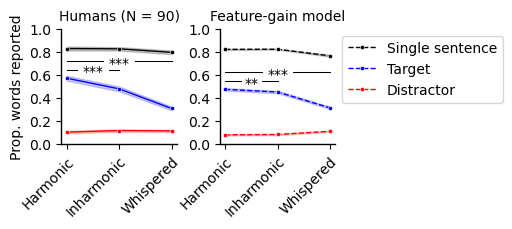

In [45]:
# def draw_stats_bar(ax, x1, x2, y, h, th=0.025, lw=1.5, col='k', fontsize=10):
#     ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=lw, c=col)
#     # edit so star is in middle of bar
#     ax.text((x1+x2)*.5, y+ th, "*", ha='center', va='center', color=col, fontsize=fontsize)

def draw_stats_bar(ax, x1, x2, y, h, text, th=0.025, lw=1.5, col='k', fontsize=10, text_gap=0.02):
    # Calculate the position of the text
    text_x = (x1 + x2) * 0.5
    text_y = y + th
    
    # Calculate the gap around the text
    gap_half_width = text_gap * len(text) # * (x2 - x1) * 0.5
    
    # Draw the left part of the bar
    ax.plot([x1, x1, text_x - gap_half_width], [y, y + h, y + h], lw=lw, c=col)
    
    # Draw the right part of the bar
    ax.plot([text_x + gap_half_width, x2, x2], [y + h, y + h, y], lw=lw, c=col)
    
    # Draw the text in the middle of the bar
    ax.text(text_x, y-0.02, text, ha='center', va='center', color=col, fontsize=fontsize)

# groups_to_plot = ['Humans (N = 90)', 'Feature-gain Model', 'Feature-gain Model New']
# groups_to_plot = ['Humans (N = 90)', 'v08 model', '50Hz cutoff', 'v09 model']
# groups_to_plot = ['Humans (N = 90)', 'Feature-gain model', 'Conventional Layer Order', '50Hz cutoff model']

group_order = ['Humans (N = 90)',
            'Feature-gain model',
            ]

groups_to_plot = group_order
n_models = len(groups_to_plot)

to_plot = melted_results[melted_results.group.isin(groups_to_plot)]
to_plot = to_plot[(to_plot.target_harmonicity == to_plot.distractor_harmonicity) | (to_plot.distractor_harmonicity == 'No Distractor')]
no_dist_IXS = to_plot[to_plot.distractor_harmonicity == 'No Distractor'].index.values
to_plot.loc[no_dist_IXS, 'distractor_harmonicity'] = to_plot.loc[no_dist_IXS, 'target_harmonicity'] 
to_plot =to_plot[to_plot.distractor_harmonicity != 'No Distractor']

hues = ['k', 'b', 'r']
hue_order = ['Single sentence', 'Target', 'Distractor']

palette = {'Target': 'b', 'Distractor': 'r', 'Single sentence': 'k'}

fontsize=10
tick_fontsize = 10
# fontsize = 10
err_band_alpha = 0.2

yticks = np.linspace(0,1,6).round(1)

xtick_labels = to_plot.distractor_harmonicity.unique()
xticks = np.arange(len(xtick_labels))
ratio = 1.0 
line_thickness = 1


aspect = 1.5
fig, axs = plt.subplots(1, n_models, figsize=((aspect) * (n_models + .5), aspect ))


for ax, model in zip(axs, group_order):
    sns.lineplot(data=to_plot[to_plot.group == model],  x='distractor_harmonicity', y='hits', 
                hue = 'attended_stream', hue_order=hue_order,
                palette=hues,
                ax=ax,
                errorbar=('se', 1), err_style='band', err_kws={'alpha':err_band_alpha},
                marker='.', 
                 )
    ax.set_title(model, fontsize=fontsize)
    ax.set_xlabel('')
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticklabels(xtick_labels, rotation=45, fontsize=tick_fontsize, ha='right', rotation_mode='anchor')
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
    #     line.set_markerfacecolor(line.get_color())
    #     line.set_markeredgecolor('w')
        line.set_linewidth(1)
        line.set_markersize(6)
        line.set_markeredgewidth(.4)
        if model != group_order[0]:
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')


## Add p-values to plot

# set up x and y positions for p-value text
x_coord_dict = {'Harmonic_Inharmonic': {'x1': 0, 'x2': 1},
                'Harmonic_Whispered': {'x1': 0, 'x2': 2},
                'Inharmonic_Whispered': {'x1': 1, 'x2': 2}}

# get y_pos for p-value text for target stream from data
group_max = to_plot[(to_plot.attended_stream == 'Target') & (to_plot.distractor_harmonicity == 'Harmonic')].groupby(['group']).hits.mean() + 0.0
inharmonic_max = to_plot[(to_plot.attended_stream == 'Target') & (to_plot.distractor_harmonicity == 'Inharmonic')].groupby(['group']).hits.mean() + 0.0
h = 0.025
ver_shift_increment = 0.075

for ax, model in zip(axs, groups_to_plot):
    if "Humans" in model:
        model_str = "Humans"
    else:
        model_str = model
    for stream in to_plot.attended_stream.unique():
        if stream != 'Target':
            continue
        for h_shift, harm_combo in enumerate(['Harmonic_Inharmonic', "Harmonic_Whispered"]):
            #get lead condition from str for x coordinate position
            first_cond, second_cond = harm_combo.split('_')
            cond_str = f"{first_cond} vs {second_cond}"
            print(model_str)
            print(cond_str)
            print(stream)

            p_val = ttest_df[(ttest_df.comparison == cond_str) & (ttest_df.group == model_str) & (ttest_df.stream == stream)].p.item()
            if p_val < 0.05:
                text = "*"
            if p_val < 0.001:
                text = "**"
            if p_val < 0.0001:
                text = "***"
            x1 = x_coord_dict[harm_combo]['x1']
            x2 = x_coord_dict[harm_combo]['x2']
            ver_shift = ver_shift_increment * (h_shift + 1) 
            if harm_combo == 'Inharmonic_Whispered':
                y = inharmonic_max[model] + ver_shift_increment
            else:
                y = group_max[model] + ver_shift
            draw_stats_bar(ax, x1, x2, y, 0, text, col='k', lw=0.75, fontsize=fontsize, text_gap=0.1)
                
sns.despine()

for ix in range(n_models-1):
    axs[ix].legend().remove()

axs[0].set_ylabel("Prop. words reported", fontsize=fontsize)
for ix in range(1, n_models):
    axs[ix].set_ylabel("", fontsize=fontsize)

# move axs[1] legend 
axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize)



# plt.tight_layout()

# fig_
# plt.savefig(fig_out_dir/'harmonicity_human_arch_sum_v10.pdf', transparent=True, bbox_inches='tight')
# 

# plot all main models

PosixPath('final_figures/figure_2')

/tmp/ipykernel_2633732/4015991441.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels, rotation=45, fontsize=tick_fontsize, ha='right', rotation_mode='anchor')
/tmp/ipykernel_2633732/4015991441.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels, rotation=45, fontsize=tick_fontsize, ha='right', rotation_mode='anchor')
/tmp/ipykernel_2633732/4015991441.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels, rotation=45, fontsize=tick_fontsize, ha='right', rotation_mode='anchor')
/tmp/ipykernel_2633732/4015991441.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


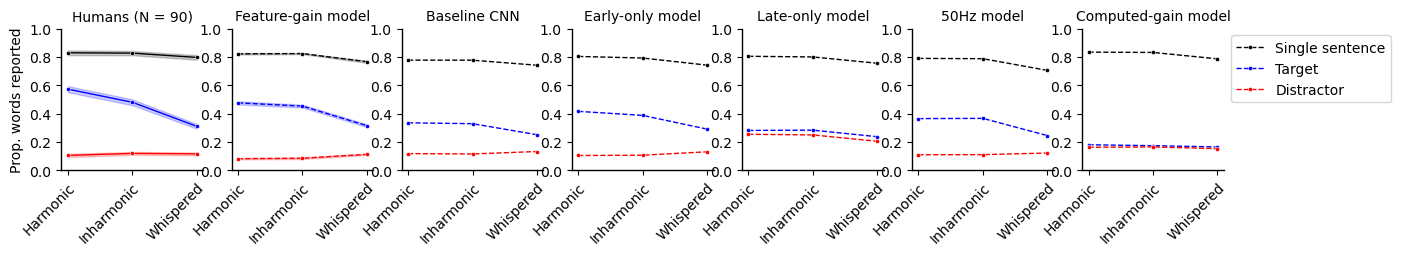

In [ ]:

def draw_stats_bar(ax, x1, x2, y, h, text, th=0.025, lw=1.5, col='k', fontsize=10, text_gap=0.02):
    # Calculate the position of the text
    text_x = (x1 + x2) * 0.5
    text_y = y + th
    
    # Calculate the gap around the text
    gap_half_width = text_gap * len(text) # * (x2 - x1) * 0.5
    
    # Draw the left part of the bar
    ax.plot([x1, x1, text_x - gap_half_width], [y, y + h, y + h], lw=lw, c=col)
    
    # Draw the right part of the bar
    ax.plot([text_x + gap_half_width, x2, x2], [y + h, y + h, y], lw=lw, c=col)
    
    # Draw the text in the middle of the bar
    ax.text(text_x, y, text, ha='center', va='center', color=col, fontsize=fontsize)

groups_to_plot = melted_results.group.unique()

n_models = len(groups_to_plot)

to_plot = melted_results[melted_results.group.isin(groups_to_plot)]
to_plot = to_plot[(to_plot.target_harmonicity == to_plot.distractor_harmonicity) | (to_plot.distractor_harmonicity == 'No Distractor')]
no_dist_IXS = to_plot[to_plot.distractor_harmonicity == 'No Distractor'].index.values
to_plot.loc[no_dist_IXS, 'distractor_harmonicity'] = to_plot.loc[no_dist_IXS, 'target_harmonicity'] 
to_plot =to_plot[to_plot.distractor_harmonicity != 'No Distractor']

hues = ['k', 'b', 'r']
hue_order = ['Single sentence', 'Target', 'Distractor']

palette = {'Target': 'b', 'Distractor': 'r', 'Single sentence': 'k'}

fontsize=10
tick_fontsize = 10
# fontsize = 10
err_band_alpha = 0.2

yticks = np.linspace(0,1,6).round(1)

xtick_labels = to_plot.distractor_harmonicity.unique()
xticks = np.arange(len(xtick_labels))
ratio = 1.0 
line_thickness = 1


aspect = 2
fig, axs = plt.subplots(1, n_models, figsize=((aspect) * (n_models + .5), aspect ))

group_order = ['Humans (N = 90)',
            'Feature-gain model',
            'Baseline CNN',
            'Early-only model',
            'Late-only model',
            '50Hz model',
            'Computed-gain model',
            ]

for ax, model in zip(axs, group_order):
    sns.lineplot(data=to_plot[to_plot.group == model],  x='distractor_harmonicity', y='hits', 
                hue = 'attended_stream', hue_order=hue_order,
                palette=hues,
                ax=ax,
                errorbar=('se', 1), err_style='band', err_kws={'alpha':err_band_alpha},
                marker='.', 
                 )
    ax.set_title(model, fontsize=fontsize)
    ax.set_xlabel('')
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticklabels(xtick_labels, rotation=45, fontsize=tick_fontsize, ha='right', rotation_mode='anchor')
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
    #     line.set_markerfacecolor(line.get_color())
    #     line.set_markeredgecolor('w')
        line.set_linewidth(1)
        line.set_markersize(6)
        line.set_markeredgewidth(.4)
        if model != group_order[0]:
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')


## Add p-values to plot

# set up x and y positions for p-value text
x_coord_dict = {'Harmonic_Inharmonic': {'x1': 0, 'x2': 1},
                'Harmonic_Whispered': {'x1': 0, 'x2': 2},
                'Inharmonic_Whispered': {'x1': 1, 'x2': 2}}

# get y_pos for p-value text for target stream from data
group_max = to_plot[(to_plot.attended_stream == 'Target') & (to_plot.distractor_harmonicity == 'Harmonic')].groupby(['group']).hits.mean()
inharmonic_max = to_plot[(to_plot.attended_stream == 'Target') & (to_plot.distractor_harmonicity == 'Inharmonic')].groupby(['group']).hits.mean()
h = 0.025
ver_shift_increment = 0.04

# for ax, model in zip(axs, groups_to_plot):
#     for stream in to_plot.attended_stream.unique():
#         if stream != 'Target':
#             continue
#         for h_shift, harm_combo in enumerate(['Harmonic_Inharmonic', 'Inharmonic_Whispered', "Harmonic_Whispered"]):
#             #get lead condition from str for x coordinate position
#             first_cond, second_cond = harm_combo.split('_')
#             # print(model)
#             p_val = p_vals_df[(p_vals_df.group == model) & (p_vals_df.attended_stream == stream) & (p_vals_df.test == harm_combo)].p_val.values[0]
#             if p_val < 0.05:
#                 text = "*"
#                 if p_val < 0.01:
#                     text = "**"
#                 if p_val < 0.001:
#                     text = "***"
#                 x1 = x_coord_dict[harm_combo]['x1']
#                 x2 = x_coord_dict[harm_combo]['x2']
#                 ver_shift = ver_shift_increment * (h_shift + 1) 
#                 if harm_combo == 'Inharmonic_Whispered':
#                     y = inharmonic_max[model] + ver_shift_increment
#                 else:
#                     y = group_max[model] + ver_shift
#                 draw_stats_bar(ax, x1, x2, y, h, text, col='k', lw=0.75, fontsize=fontsize, text_gap=0.1)
                
sns.despine()
# turn off axs[0] legend 
# axs[0].legend().remove()
# axs[1].legend().remove()
# axs[0].set_ylabel("Prop. target word", fontsize=fontsize)
# axs[1].set_ylabel("", fontsize=fontsize)
# axs[2].set_ylabel("", fontsize=fontsize)

# # move axs[1] legend 
# axs[2].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize)
# # plt.subplots_adjust(wspace=0.5)

for ix in range(n_models-1):
    axs[ix].legend().remove()

axs[0].set_ylabel("Prop. words reported", fontsize=fontsize)
for ix in range(1, n_models):
    axs[ix].set_ylabel("", fontsize=fontsize)

# move axs[1] legend 
axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize)

# plt.tight_layout()
# plt.savefig(outfig_dest/'harmonicity_human_arch_sum_v09.pdf', transparent=True, bbox_inches='tight')


## Save summary to compare 


In [72]:
### Summarize models like participants 
fba_models = model_results[~model_results.model.str.contains('early|late|control|50Hz|backbone')].copy()


fba_summary = (fba_models.groupby(['model', "target_harmonicity", 'distractor_harmonicity']).agg({
                            'adjusted_accuracy':['mean', 'sem'],
                            'adjusted_confusions':['mean', 'sem', 'count']})
                     .reset_index())

# # flatten multiindex 
fba_summary.columns = ['_'.join(col).strip() for col in fba_summary.columns.values]
# # remove trailing underscore
fba_summary.columns = [col[:-1] if col.endswith('_') else col for col in fba_summary.columns.values]
### not summarize across models 


fba_to_save = fba_summary.groupby(['target_harmonicity', 'distractor_harmonicity']).agg({'adjusted_accuracy_mean':['mean', 'sem'], 'adjusted_confusions_mean':['mean', 'sem', 'count']}).reset_index()
fba_to_save.columns = ['target_harmonicity', 'distractor_harmonicity', 'accuracy', 'accuracy_sem', 'confusions', 'confusions_sem', 'N']
fba_summary.columns = ['model', 'target_harmonicity', 'distractor_harmonicity', 'accuracy', 'accuracy_sem', 'confusions', 'confusions_sem', 'N']
fba_to_save['group'] = 'Feature-gain Model'
fba_summary['group'] = 'Feature-gain Model'
# fba_to_save


In [80]:
### For other models, bootstrap for SEM 

def bootstrap_sem(data, n_bootstraps=1000):
    bootstrapped_means = np.zeros(n_bootstraps)
    n = len(data)
    for i in range(n_bootstraps):
        bootstrapped_sample = np.random.choice(data, size=n, replace=True)
        bootstrapped_means[i] = bootstrapped_sample.mean()
    return bootstrapped_means.std()

control_models = model_results[model_results.model.str.contains('early|late|control|50Hz|backbone')].copy()
# control_to_save = (control_models.groupby(['model', "target_harmonicity", 'distractor_harmonicity']).agg({
#                             'adjusted_accuracy':['mean'],
#                             'adjusted_confusions':['mean', 'count']})
#                      .reset_index())
control_summary = []
for (model, target_harm, dist_harm), group in control_models.groupby(['model', 'target_harmonicity', 'distractor_harmonicity']):
    accs = group.adjusted_accuracy.values
    confs = group.adjusted_confusions.values
    acc_sem = bootstrap_sem(accs)
    conf_sem = bootstrap_sem(confs)
    if 'early' in model:
        model = 'Early-only'
    elif 'late' in model:
        model = 'Late-only'
    elif 'control' in model:
        model = 'Baseline CNN'
    elif '50Hz' in model:
        model = '50Hz cutoff'
    elif 'backbone' in model:
        model = 'Computed-gain model'
    control_summary.append(
                            {'model':model, 'target_harmonicity': target_harm, 'distractor_harmonicity': dist_harm, 
                             'accuracy': accs.mean(), 'accuracy_sem': acc_sem, 'confusions': confs.mean(), 'confusions_sem': conf_sem}
    ) 
control_to_save = pd.DataFrame(control_summary)
control_to_save['N'] = 1
control_to_save['group'] = control_to_save['model']
control_to_save.head()

,model,target_harmonicity,distractor_harmonicity,accuracy,accuracy_sem,confusions,confusions_sem,N,group
0,Early-only,Harmonic,Harmonic,0.415984,0.011246,0.104508,0.006826,1,Early-only
1,Early-only,Harmonic,Inharmonic,0.390369,0.010636,0.108094,0.007423,1,Early-only
2,Early-only,Harmonic,No Distractor,0.803279,0.008855,0.001025,0.000722,1,Early-only
3,Early-only,Harmonic,Whispered,0.369877,0.010873,0.077357,0.006253,1,Early-only
4,Early-only,Inharmonic,Harmonic,0.394980,0.011162,0.100922,0.006921,1,Early-only


In [81]:
human_to_save = part_summary_df.groupby(['target_harmonicity', 'distractor_harmonicity']).agg({'adjusted_accuracy_mean':['mean', 'sem'], 'adjusted_confusions_mean':['mean', 'sem', 'count']}).reset_index()
human_to_save.columns = ['target_harmonicity', 'distractor_harmonicity', 'accuracy', 'accuracy_sem', 'confusions', 'confusions_sem', 'N']
human_to_save['group'] = f'Humans (N = {part_summary_df.id_subject.nunique()})'
# human_to_save

In [87]:
### Save grouped data for stats 
df_for_stats = pd.concat([human_to_save, fba_summary, control_to_save], axis=0, ignore_index=True)
df_for_stats['background_condition'] = df_for_stats['target_harmonicity'] + '_target_' + df_for_stats['distractor_harmonicity'] + '_distractor'
df_for_stats.drop(['target_harmonicity', 'distractor_harmonicity'], axis=1, inplace=True)
df_for_stats.columns = ['accuracy', 'acc_sem', 'confusions', 'conf_sem', 'N', 'group', 'model', 'background_condition']
out_dir = Path('final_results_dir')
out_name = out_dir / f"df_for_stats_2024_SWC_popham_conditions_humans_N-90_models_v10_w_control_50Hz_ECDF_models.pdpkl"
# df_for_stats.to_pickle(out_name)


In [88]:
df_for_stats.model.value_counts() ## Is of if backbone only has 6 - we're only plotting these (with/without distractor x harmonic, inharmoinc, whispered)

model
word_task_v10_4MGB_ln_first_arch_1        12
word_task_v10_4MGB_ln_first_arch_10       12
word_task_v10_4MGB_ln_first_arch_12       12
word_task_v10_4MGB_ln_first_arch_2        12
word_task_v10_4MGB_ln_first_arch_4        12
word_task_v10_4MGB_ln_first_arch_6        12
word_task_v10_4MGB_ln_first_arch_7        12
word_task_v10_4MGB_ln_first_arch_9        12
word_task_v10_main_feature_gain_config    12
Early-only                                12
50Hz cutoff                               12
Late-only                                 12
Baseline CNN                              12
word_task_v10_4MGB_ln_first_arch_8        11
Computed-gain model                        6
Name: count, dtype: int64

In [92]:
### Merge two dfs and save 
summary_to_save = pd.concat([human_to_save, fba_to_save, control_to_save], axis=0, ignore_index=True)

summary_to_save['condition'] = summary_to_save['target_harmonicity'] + '_target_' + summary_to_save['distractor_harmonicity'] + '_distractor'
summary_to_save.drop(['target_harmonicity', 'distractor_harmonicity'], axis=1, inplace=True)

out_dir = Path('final_results_dir')
out_name = out_dir / f"summary_2024_SWC_popham_conditions_humans_N-90_models_v10_w_control_50Hz_ECDF_models.pdpkl"
# summary_to_save.to_pickle(out_name)
# summary_to_save

In [93]:
summary_to_save.group.value_counts()

group
Humans (N = 90)        12
Feature-gain Model     12
Early-only             12
50Hz cutoff            12
Late-only              12
Baseline CNN           12
Computed-gain model     6
Name: count, dtype: int64

In [ ]:
results_dir = Path('final_results_dir')


summary_to_save.loc[summary_to_save.group.str.contains("Human"), 'model'] = summary_to_save.loc[summary_to_save.group.str.contains("Human"), 'group']
summary_to_save['snr'] = 0 # add snr column to match diotic_results
popham_conds_to_keep = ['Harmonic_target_Harmonic_distractor',
                        'Harmonic_target_No Distractor_distractor',
                        'Inharmonic_target_Inharmonic_distractor',
                        'Inharmonic_target_No Distractor_distractor',
                        'Whispered_target_No Distractor_distractor',
                        'Whispered_target_Whispered_distractor']

summary_to_save = summary_to_save[summary_to_save['background_condition'].isin(popham_conds_to_keep)].reset_index(drop=True)
summary_to_save = summary_to_save[~summary_to_save.model.str.contains('50Hz')].reset_index(drop=True)
# summary_to_save.to_csv(results_dir / "experiment_2_df.csv", index=False)